In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import pickle
import os
from sklearn.decomposition import NMF, PCA
from sklearn.cluster import KMeans
from importlib import reload

import sys
sys.path.insert(1, '../t-recs/')
from trecs.metrics import Measurement
from trecs.metrics import MSEMeasurement, InteractionSpread, InteractionSpread, InteractionSimilarity, RecSimilarity, RMSEMeasurement, InteractionMeasurement
from trecs.components import Users
import trecs.matrix_ops as mo
import src.globals as globals
import seaborn as sns

from wrapper.models.bubble import BubbleBurster
from src.utils import *
from src.plotting import plot_measurements 
from src.scoring_functions import cosine_sim, entropy, content_fairness, top_k_reranking
from wrapper.metrics.evaluation_metrics import *

random_state = np.random.seed(42)
plt.style.use("seaborn")

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

globals.initialize()

/var/folders/sm/hcy50x855gvf2b1qwkjstnvh0000gn/T/ipykernel_50315/2185722975.py:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [111]:
def plot_homogenization(dfs, parameters, training_between):
    fig, ax = plt.subplots(2, 4, figsize=(20, 10))
    fig.tight_layout(pad=5.0)
    colors = plt.get_cmap('tab10')

    # plot rec_similarity with timesteps on x axis
    # idxs = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1), (3,0), (3,1)]
    idxs = [(0,0), (0,1), (0,2), (0,3), (1,0), (1,1), (1,2), (1,3)]
    legend_lines, legend_names = [], []
    for i, df in enumerate(dfs):
        ts = df['timesteps']
        name = parameters[i][0]
        # if not np.isnan(parameters_df.loc[i, 'Lambda']):
        #     name += f" (Lambda: {parameters_df.loc[i, 'Lambda']})"
        legend_names.append(name)
        
        line, = ax[idxs[0]].plot(ts, df['inter_cluster_interaction_similarity'], label=name, alpha=0.5, color=colors(i))
        if 'intra_cluster_interaction_similarity' in df.columns:
            ax[idxs[1]].plot(ts, df['intra_cluster_interaction_similarity'], label=name, alpha=0.5, color=colors(i))
        if 'inter_cluster_rec_similarity' in df.columns:
            ax[idxs[2]].plot(ts, df['inter_cluster_rec_similarity'], label=name, alpha=0.5, color=colors(i))
        if 'intra_cluster_rec_similarity' in df.columns:
            ax[idxs[3]].plot(ts, df['intra_cluster_rec_similarity'], label=name, alpha=0.5, color=colors(i))
        if 'interaction_spread' in df.columns:
            ax[idxs[4]].plot(ts, df['interaction_spread'], label=name, alpha=0.5, color=colors(i))
        if 'mean_num_topics' in df.columns:
            ax[idxs[5]].plot(ts, df['mean_num_topics'], label=name, alpha=0.5, color=colors(i))
        
        ratio_intrxn_sim = np.divide(df['intra_cluster_interaction_similarity'], df['inter_cluster_interaction_similarity'])
        ax[idxs[6]].plot(ts, ratio_intrxn_sim, label=name, alpha=0.5, color=colors(i))
        
        ratio_rec_sim = np.divide(df['intra_cluster_rec_similarity'], df['inter_cluster_rec_similarity'])
        ax[idxs[7]].plot(ts, ratio_rec_sim, label=name, alpha=0.5, color=colors(i))
        
        legend_lines.append(line)

    for a in ax:
        for b in a:
            b.set_xlabel('Timestep')
            
    title_suffix = ''
            
    if training_between:
        title_suffix = '(Training between timesteps)'
    else:
        title_suffix = '(No training between timesteps)'

    ax[idxs[0]].set_title(f"Inter Cluster Interaction Similarity\n{title_suffix}")
    ax[idxs[0]].set_ylabel('Jaccard Similarity')

    ax[idxs[1]].set_title(f"Intra Cluster Interaction Similarity\n{title_suffix}")
    ax[idxs[1]].set_ylabel('Jaccard Similarity')
    
    ax[idxs[2]].set_title(f"'Inter Cluster Recommendation similarity\n{title_suffix}")
    ax[idxs[2]].set_ylabel('Jaccard Similarity')

    ax[idxs[3]].set_title(f"Intra Cluster Recommendation similarity\n{title_suffix}")
    ax[idxs[3]].set_ylabel('Jaccard Similarity')
    
    ax[idxs[4]].set_title(f"Interaction Spread\n{title_suffix}")
    ax[idxs[4]].set_ylabel('Jaccard Similarity')

    ax[idxs[5]].set_title(f"Mean Number of Topics Interacted per User\n{title_suffix}")
    ax[idxs[5]].set_ylabel('Mean Number of Topics Interacted per User')
    
    ax[idxs[6]].set_title(f"Interaction Similarity Ratio, Intra-Cluster:Inter-Cluster\n{title_suffix}")
    ax[idxs[6]].set_ylabel('Jaccard Similarity')
    
    ax[idxs[7]].set_title(f"Recommendation Similarity Ratio, Intra-Cluster:Inter-Cluster\n{title_suffix}")
    ax[idxs[7]].set_ylabel('Jaccard Similarity')

    fig.legend(legend_lines,
               legend_names,
               loc='upper center',
               fontsize=12,
               frameon=False,
               ncol=5,
               bbox_to_anchor=(.5, 1.02))
    
    for i in idxs:
        if training_between:
            ax[i].legend(loc='upper left')
        else:
            ax[i].legend(loc='lower right')
    
    ax[idxs[4]].legend(loc='lower right')
    ax[idxs[5]].legend(loc='lower right')
    
    ax[idxs[-1]].legend(loc='upper right')
    ax[idxs[-2]].legend(loc='upper right')
    
    if training_between:
        plt.savefig('figures/YES_train_between_homogen_analysis.png')
    else:
        plt.savefig('figures/NO_train_between_homogen_analysis.png')
    
    # fig.legend(legend_lines, legend_names)#, loc='upper center', fontsize=14, frameon=False, ncol=5, bbox_to_anchor=(.5, 1.05))
    # plt.legend()

# Train between timesteps

In [112]:
paths = [
    ('cosine_sim','artefacts/supplementary/measurements/cosine_sim_measurements_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp_0.1Lambda.csv'),
    ('entropy','artefacts/supplementary/measurements/entropy_measurements_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp_10Lambda.csv'),
    ('top_k_reranking','artefacts/supplementary/measurements/top_k_reranking_measurements_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp.csv'),
    ('myopic','artefacts/supplementary/measurements/myopic_measurements_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp.csv')
]

# paths
dfs_homogen = []
for i in paths:
    df = pd.read_csv(i[1])
    dfs_homogen.append(df)

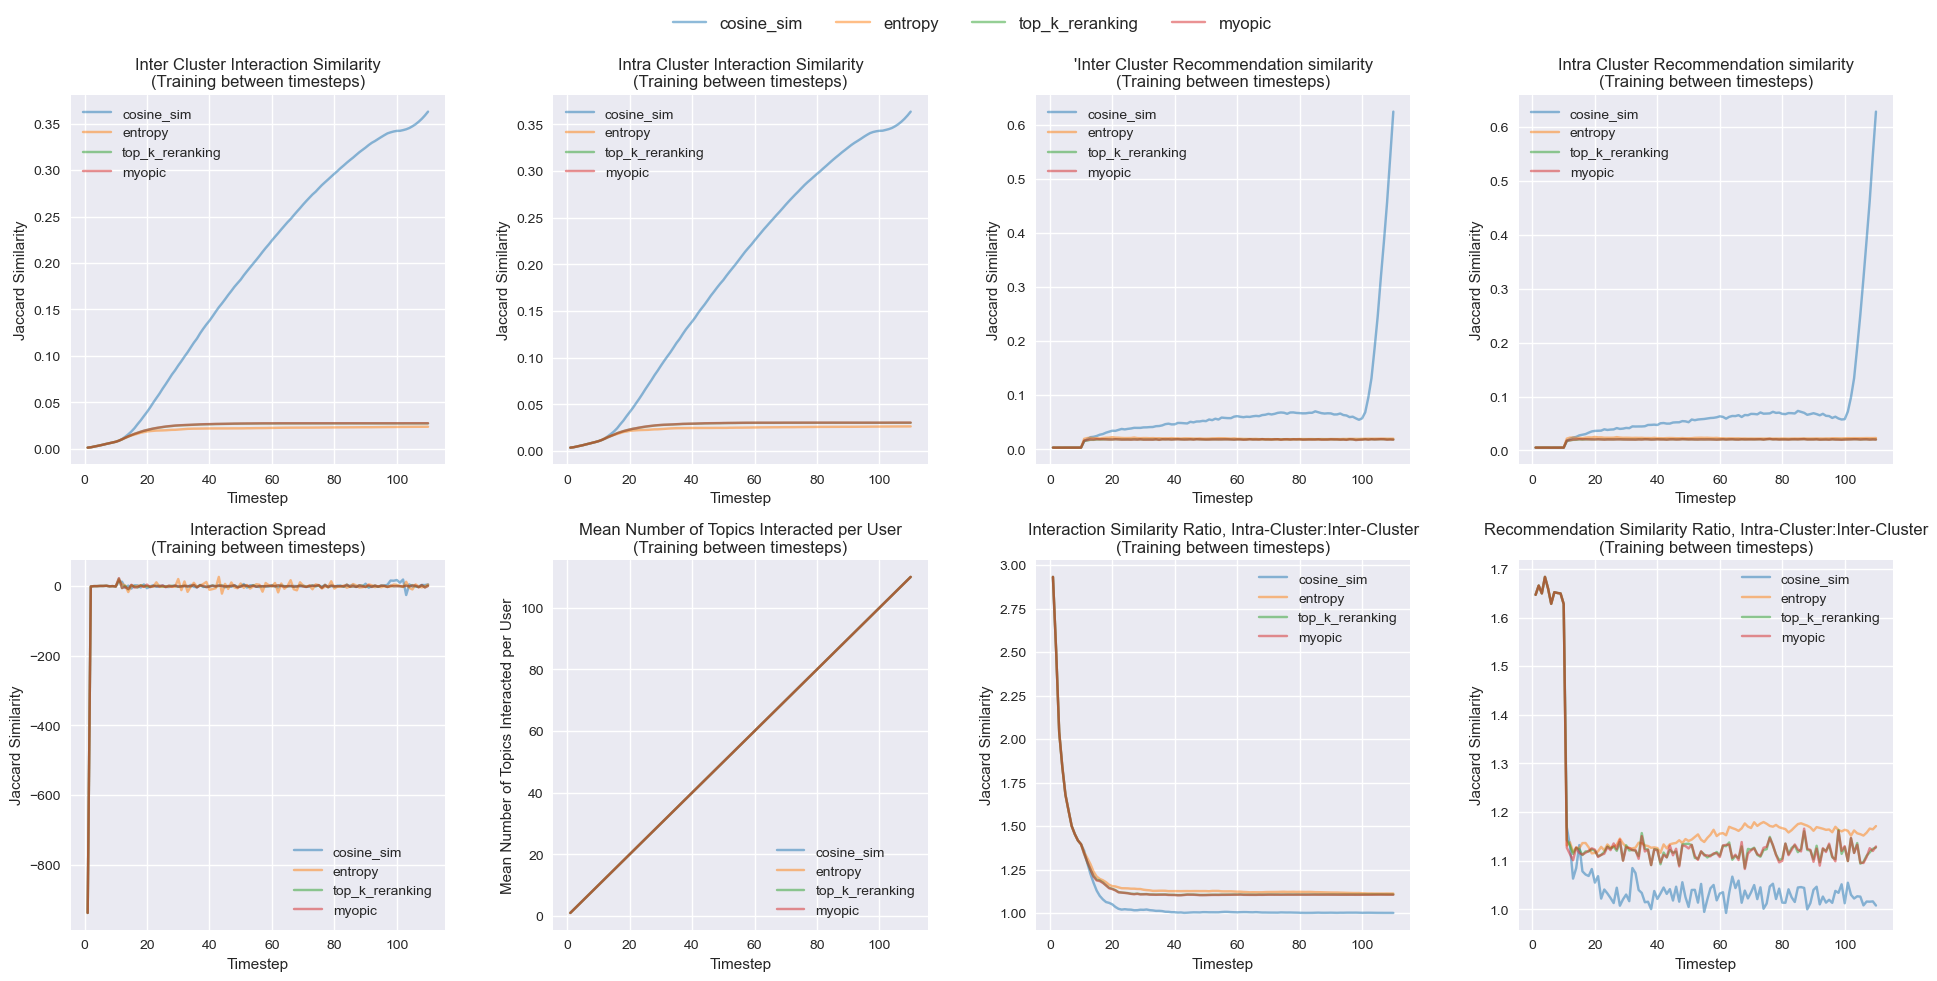

In [113]:
plot_homogenization(dfs_homogen, paths, training_between=True)

# Testing NO training between steps

In [114]:
paths = [
    ('cosine_sim','artefacts/no_train_between_runs/supplementary/measurements/cosine_sim_measurements_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp_10Lambda.csv'),
    ('entropy','artefacts/no_train_between_runs/supplementary/measurements/entropy_measurements_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp_1.0Lambda.csv'),
    ('top_k_reranking','artefacts/no_train_between_runs/supplementary/measurements/top_k_reranking_measurements_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp.csv'),
    ('myopic','artefacts/no_train_between_runs/supplementary/measurements/myopic_measurements_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp.csv')
]

# paths
dfs_homogen = []
for i in paths:
    df = pd.read_csv(i[1])
    dfs_homogen.append(df)

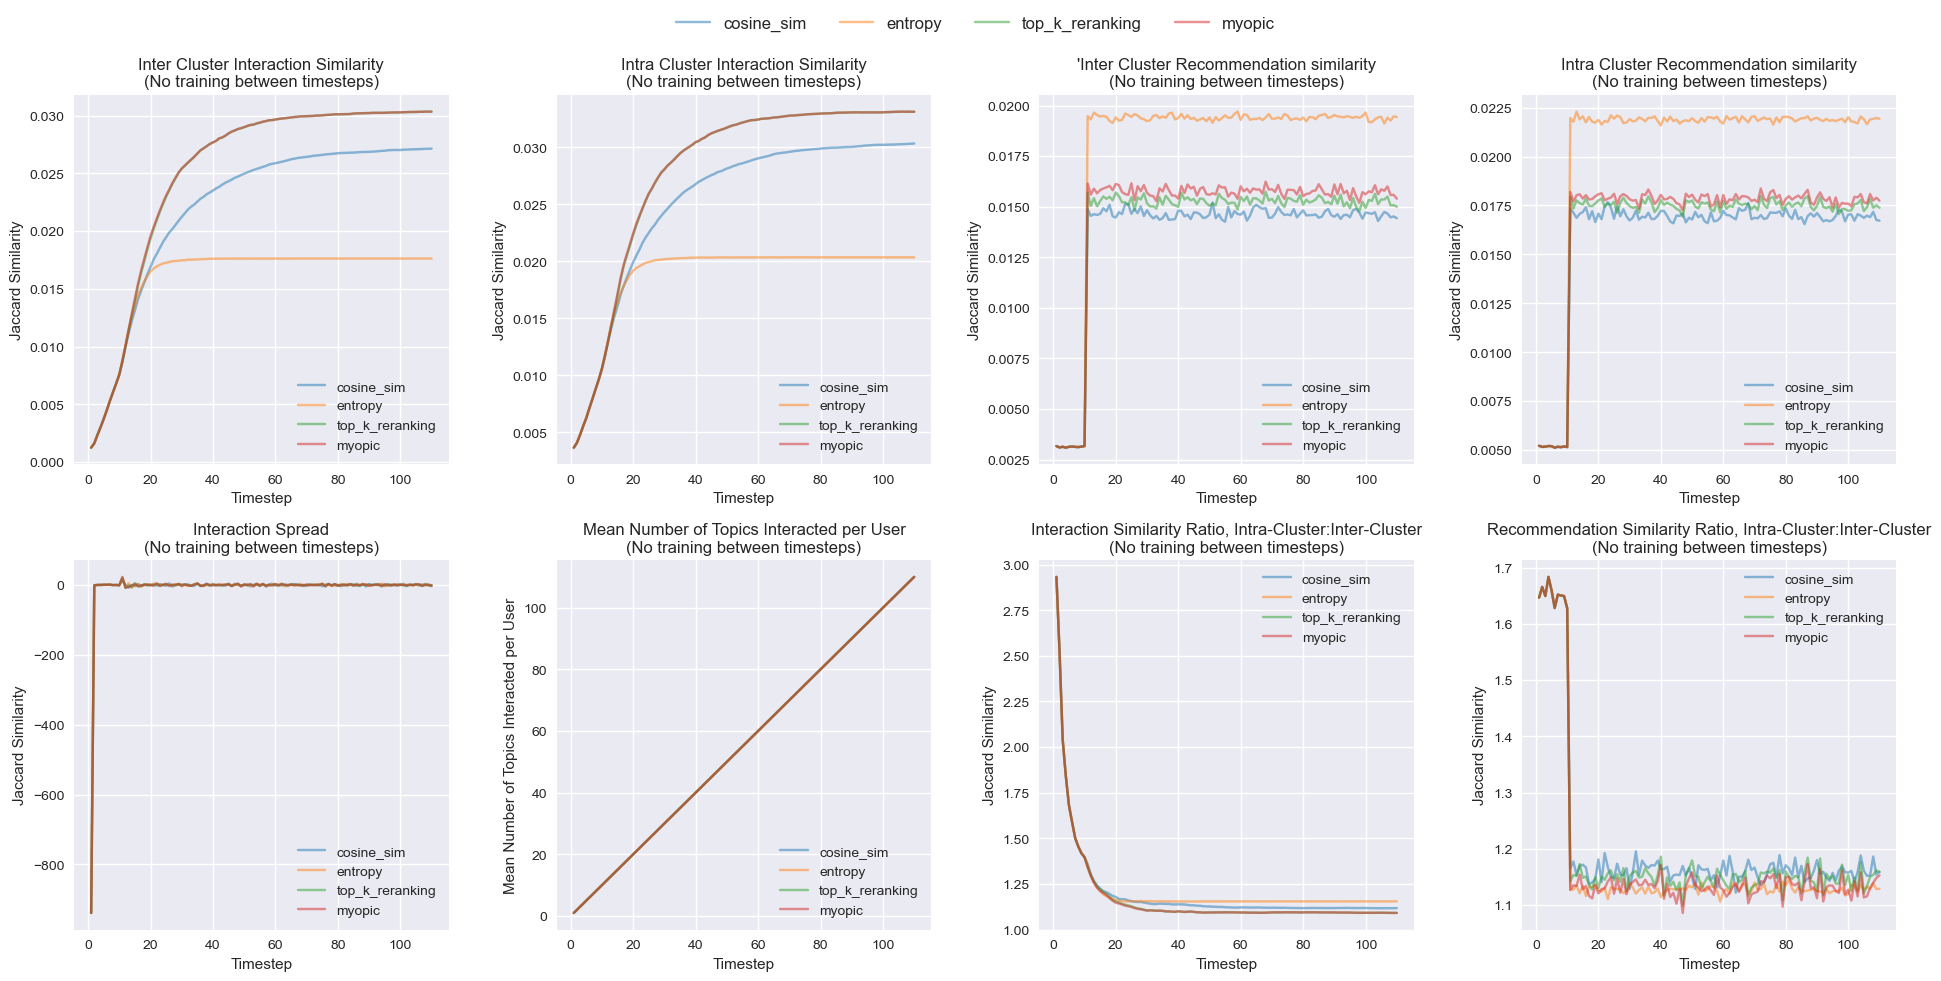

In [115]:
plot_homogenization(dfs_homogen, paths, training_between=False)

# Plotting just ratios

In [162]:
def plot_ratios1(dfs, parameters):
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    fig.tight_layout(pad=5.0)
    colors = plt.get_cmap('tab10')

    # plot rec_similarity with timesteps on x axis
    # idxs = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1), (3,0), (3,1)]
    idxs = [0,1,2,3]
    legend_lines, legend_names = [], []
    for i, df in enumerate(dfs):
        ts = df['timesteps']
        name = parameters[i][0]
        # if not np.isnan(parameters_df.loc[i, 'Lambda']):
        #     name += f" (Lambda: {parameters_df.loc[i, 'Lambda']})"
        legend_names.append(name)
        
        if i < len(parameters)/2:
            
            ratio_intrxn_sim = np.divide(df['intra_cluster_interaction_similarity'], df['inter_cluster_interaction_similarity'])
            line, = ax[idxs[0]].plot(ts, ratio_intrxn_sim, label=name, alpha=0.5, color=colors(i))
            
            ratio_rec_sim = np.divide(df['intra_cluster_rec_similarity'], df['inter_cluster_rec_similarity'])
            ax[idxs[1]].plot(ts, ratio_rec_sim, label=name, alpha=0.5, color=colors(i))
            
        else:
            ratio_intrxn_sim = np.divide(df['intra_cluster_interaction_similarity'], df['inter_cluster_interaction_similarity'])
            line, = ax[idxs[2]].plot(ts, ratio_intrxn_sim, label=name, alpha=0.5, color=colors(i))
            
            ratio_rec_sim = np.divide(df['intra_cluster_rec_similarity'], df['inter_cluster_rec_similarity'])
            ax[idxs[3]].plot(ts, ratio_rec_sim, label=name, alpha=0.5, color=colors(i))
        
        legend_lines.append(line)

    for a in ax:
        a.set_xlabel('Timestep')
    
    title_suffix = '(Training between timesteps)'
    
    ax[idxs[0]].set_title(f"Interaction Similarity Ratio, Intra-Cluster:Inter-Cluster\n{title_suffix}")
    ax[idxs[0]].set_ylabel('Jaccard Similarity')
    
    ax[idxs[1]].set_title(f"Recommendation Similarity Ratio, Intra-Cluster:Inter-Cluster\n{title_suffix}")
    ax[idxs[1]].set_ylabel('Jaccard Similarity')
    
    title_suffix = '(No training between timesteps)'
    
    ax[idxs[2]].set_title(f"Interaction Similarity Ratio, Intra-Cluster:Inter-Cluster\n{title_suffix}")
    ax[idxs[2]].set_ylabel('Jaccard Similarity')
    
    ax[idxs[3]].set_title(f"Recommendation Similarity Ratio, Intra-Cluster:Inter-Cluster\n{title_suffix}")
    ax[idxs[3]].set_ylabel('Jaccard Similarity')

    # fig.legend(legend_lines,
    #            legend_names,
    #            loc='upper center',
    #            fontsize=12,
    #            frameon=False,
    #            ncol=5,
    #            bbox_to_anchor=(.5, 1.02))
    
    for i in idxs:
        ax[i].legend(loc='upper right')
    
    plt.savefig('figures/train_vs_no_train_homogen_analysis.png')
    
    # fig.legend(legend_lines, legend_names)#, loc='upper center', fontsize=14, frameon=False, ncol=5, bbox_to_anchor=(.5, 1.05))
    # plt.legend()

In [163]:
paths = [
    ('cosine_sim','artefacts/supplementary/measurements/cosine_sim_measurements_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp_0.1Lambda.csv'),
    ('entropy','artefacts/supplementary/measurements/entropy_measurements_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp_10Lambda.csv'),
    ('top_k_reranking','artefacts/supplementary/measurements/top_k_reranking_measurements_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp.csv'),
    ('myopic','artefacts/supplementary/measurements/myopic_measurements_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp.csv'),
    ('cosine_sim','artefacts/no_train_between_runs/supplementary/measurements/cosine_sim_measurements_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp_10Lambda.csv'),
    ('entropy','artefacts/no_train_between_runs/supplementary/measurements/entropy_measurements_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp_1.0Lambda.csv'),
    ('top_k_reranking','artefacts/no_train_between_runs/supplementary/measurements/top_k_reranking_measurements_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp.csv'),
    ('myopic','artefacts/no_train_between_runs/supplementary/measurements/myopic_measurements_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp.csv')
]

# paths
dfs_homogen = []
for i in paths:
    df = pd.read_csv(i[1])
    dfs_homogen.append(df)

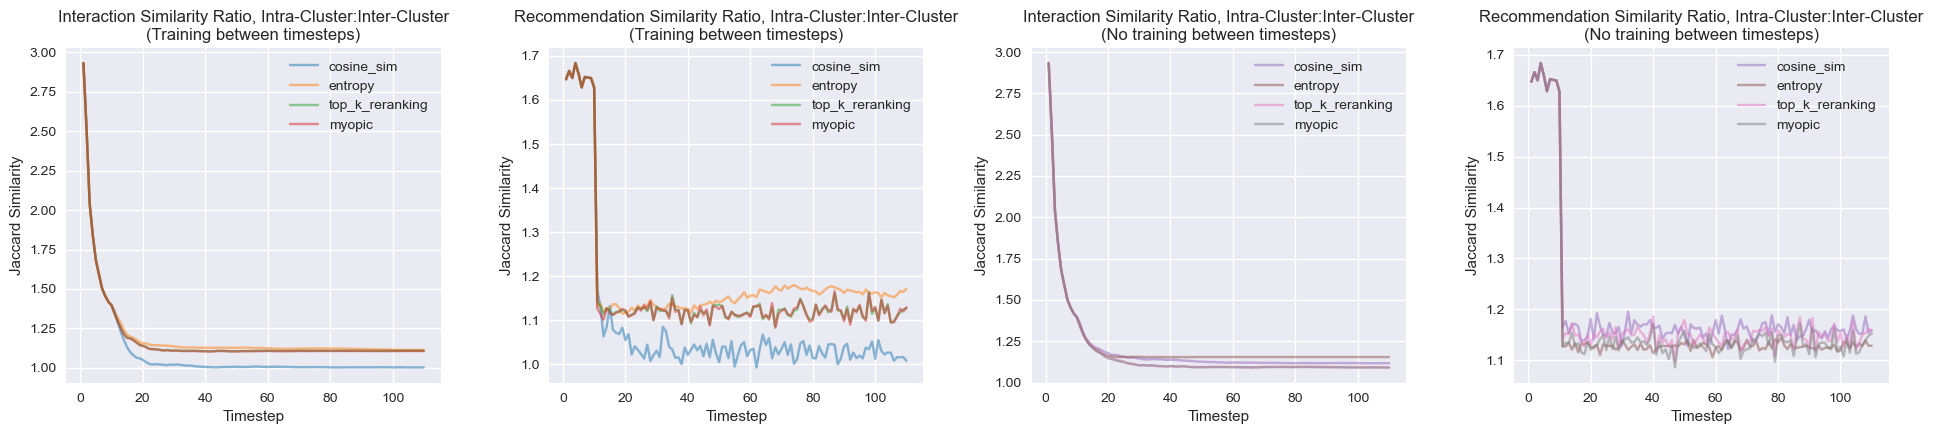

In [164]:
plot_ratios1(dfs_homogen, paths)

In [198]:
def plot_ratios2(dfs, parameters):
    fig, ax = plt.subplots(2, 4, figsize=(20, 8))
    fig.tight_layout(pad=5.0)
    colors = plt.get_cmap('tab10')

    # plot rec_similarity with timesteps on x axis
    idxs = [(0,0), (0,1), (0,2), (0,3), (1,0), (1,1), (1,2), (1,3)]
    # idxs = [0,1,2,3]
    legend_lines, legend_names = [], []
    
    for i, df in enumerate(dfs):
        ts = df['timesteps']
        name = parameters[i][0]
        # if not np.isnan(parameters_df.loc[i, 'Lambda']):
        #     name += f" (Lambda: {parameters_df.loc[i, 'Lambda']})"
        legend_names.append(name)
        
        if (i%4) == 0:
            ratio_intrxn_sim = np.divide(df['intra_cluster_interaction_similarity'], df['inter_cluster_interaction_similarity'])
            line, = ax[idxs[0]].plot(ts, ratio_intrxn_sim, label=name, alpha=0.5, color=colors(i))
            
            ratio_rec_sim = np.divide(df['intra_cluster_rec_similarity'], df['inter_cluster_rec_similarity'])
            ax[idxs[4]].plot(ts, ratio_rec_sim, label=name, alpha=0.5, color=colors(i))
            
        elif (i%4) == 1:
            ratio_intrxn_sim = np.divide(df['intra_cluster_interaction_similarity'], df['inter_cluster_interaction_similarity'])
            line, = ax[idxs[1]].plot(ts, ratio_intrxn_sim, label=name, alpha=0.5, color=colors(i))
            
            ratio_rec_sim = np.divide(df['intra_cluster_rec_similarity'], df['inter_cluster_rec_similarity'])
            ax[idxs[5]].plot(ts, ratio_rec_sim, label=name, alpha=0.5, color=colors(i))
            
        elif (i%4) == 2:
            ratio_intrxn_sim = np.divide(df['intra_cluster_interaction_similarity'], df['inter_cluster_interaction_similarity'])
            line, = ax[idxs[2]].plot(ts, ratio_intrxn_sim, label=name, alpha=0.5, color=colors(i))
            
            ratio_rec_sim = np.divide(df['intra_cluster_rec_similarity'], df['inter_cluster_rec_similarity'])
            ax[idxs[6]].plot(ts, ratio_rec_sim, label=name, alpha=0.5, color=colors(i))
            
        else:
            ratio_intrxn_sim = np.divide(df['intra_cluster_interaction_similarity'], df['inter_cluster_interaction_similarity'])
            line, = ax[idxs[3]].plot(ts, ratio_intrxn_sim, label=name, alpha=0.5, color=colors(i))
            
            ratio_rec_sim = np.divide(df['intra_cluster_rec_similarity'], df['inter_cluster_rec_similarity'])
            ax[idxs[7]].plot(ts, ratio_rec_sim, label=name, alpha=0.5, color=colors(i))
            
        print(i, "-", name)
        
        legend_lines.append(line)

    for a in ax:
        for b in a:
            b.set_xlabel('Timestep')
    
    prefix = "cosine_sim"
    ax[idxs[0]].set_title(f"{prefix}\nInteraction Similarity Ratio, Intra-Cluster:Inter-Cluster")
    ax[idxs[0]].set_ylabel('Jaccard Similarity')
    
    ax[idxs[4]].set_title(f"{prefix}\nRecommendation Similarity Ratio, Intra-Cluster:Inter-Cluster")
    ax[idxs[4]].set_ylabel('Jaccard Similarity')
    
    prefix = "entropy"
    ax[idxs[1]].set_title(f"{prefix}\nInteraction Similarity Ratio, Intra-Cluster:Inter-Cluster")
    ax[idxs[1]].set_ylabel('Jaccard Similarity')
    
    ax[idxs[5]].set_title(f"{prefix}\nRecommendation Similarity Ratio, Intra-Cluster:Inter-Cluster")
    ax[idxs[5]].set_ylabel('Jaccard Similarity')
    
    prefix = "top_k_reranking"
    ax[idxs[2]].set_title(f"{prefix}\nInteraction Similarity Ratio, Intra-Cluster:Inter-Cluster")
    ax[idxs[2]].set_ylabel('Jaccard Similarity')
    
    ax[idxs[6]].set_title(f"{prefix}\nRecommendation Similarity Ratio, Intra-Cluster:Inter-Cluster")
    ax[idxs[6]].set_ylabel('Jaccard Similarity')
    
    prefix = "myopic"
    ax[idxs[3]].set_title(f"{prefix}\nInteraction Similarity Ratio, Intra-Cluster:Inter-Cluster")
    ax[idxs[3]].set_ylabel('Jaccard Similarity')
    
    ax[idxs[7]].set_title(f"{prefix}\nRecommendation Similarity Ratio, Intra-Cluster:Inter-Cluster")
    ax[idxs[7]].set_ylabel('Jaccard Similarity')

    # fig.legend(legend_lines,
    #            legend_names,
    #            loc='upper center',
    #            fontsize=12,
    #            frameon=False,
    #            ncol=5,
    #            bbox_to_anchor=(.5, 1.02))
    
    for i in idxs:
        ax[i].legend(loc='upper right')
    
    plt.savefig('figures/train_vs_no_train_homogen_analysis.png')
    
    # fig.legend(legend_lines, legend_names)#, loc='upper center', fontsize=14, frameon=False, ncol=5, bbox_to_anchor=(.5, 1.05))
    # plt.legend()

In [199]:
paths = [
    ('cosine_sim - retrain','artefacts/supplementary/measurements/cosine_sim_measurements_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp_0.1Lambda.csv'),
    ('entropy - retrain','artefacts/supplementary/measurements/entropy_measurements_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp_10Lambda.csv'),
    ('top_k_reranking - retrain','artefacts/supplementary/measurements/top_k_reranking_measurements_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp.csv'),
    ('myopic - retrain','artefacts/supplementary/measurements/myopic_measurements_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp.csv'),
    ('cosine_sim - no retrain','artefacts/no_train_between_runs/supplementary/measurements/cosine_sim_measurements_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp_10Lambda.csv'),
    ('entropy - no retrain','artefacts/no_train_between_runs/supplementary/measurements/entropy_measurements_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp_1.0Lambda.csv'),
    ('top_k_reranking - no retrain','artefacts/no_train_between_runs/supplementary/measurements/top_k_reranking_measurements_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp.csv'),
    ('myopic - no retrain','artefacts/no_train_between_runs/supplementary/measurements/myopic_measurements_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp.csv')
]

# paths
dfs_homogen = []
for i in paths:
    df = pd.read_csv(i[1])
    dfs_homogen.append(df)

0 - cosine_sim - retrain
1 - entropy - retrain
2 - top_k_reranking - retrain
3 - myopic - retrain
4 - cosine_sim - no retrain
5 - entropy - no retrain
6 - top_k_reranking - no retrain
7 - myopic - no retrain


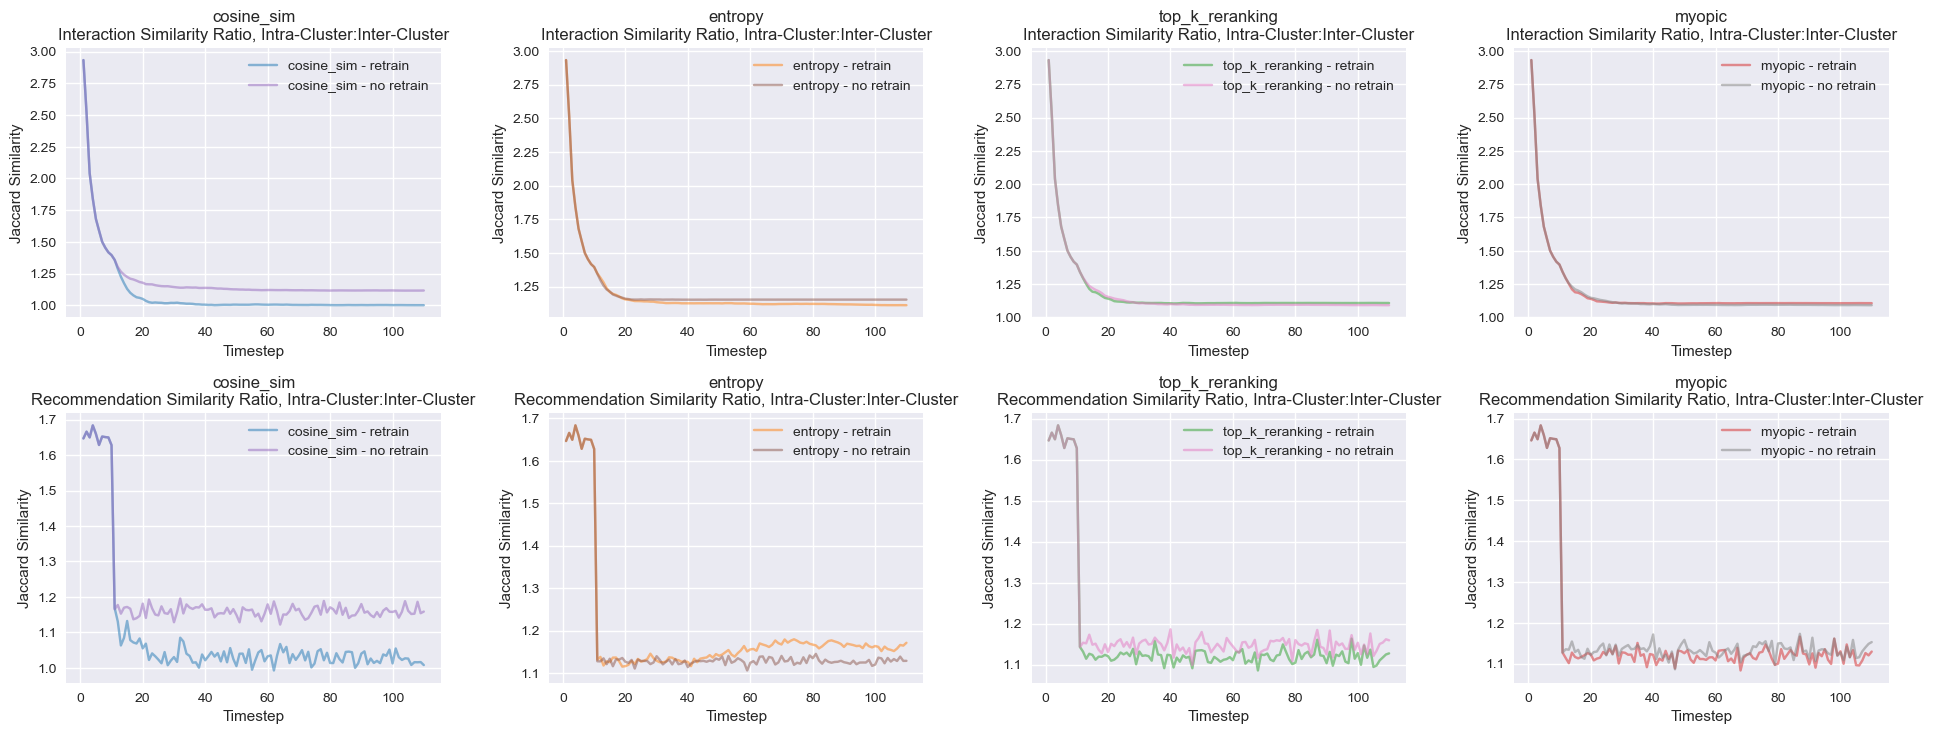

In [200]:
plot_ratios2(dfs_homogen, paths)

('cosine_sim', 'artefacts/supplementary/measurements/cosine_sim_measurements_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp_0.1Lambda.csv')
('cosine_sim', 'artefacts/no_train_between_runs/supplementary/measurements/cosine_sim_measurements_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp_10Lambda.csv') 

('entropy', 'artefacts/supplementary/measurements/entropy_measurements_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp_10Lambda.csv')
('entropy', 'artefacts/no_train_between_runs/supplementary/measurements/entropy_measurements_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp_1.0Lambda.csv') 

('top_k_reranking', 'artefacts/supplementary/measurements/top_k_reranking_measurements_10trainTimesteps_100runTimesteps_20nAttrs_25nClusters_0.05Drift_-0.8AttentionExp.csv')
('top_k_reranking', 'artefacts/no_train_between_runs/supplementary/measurements/top_k_reranking_

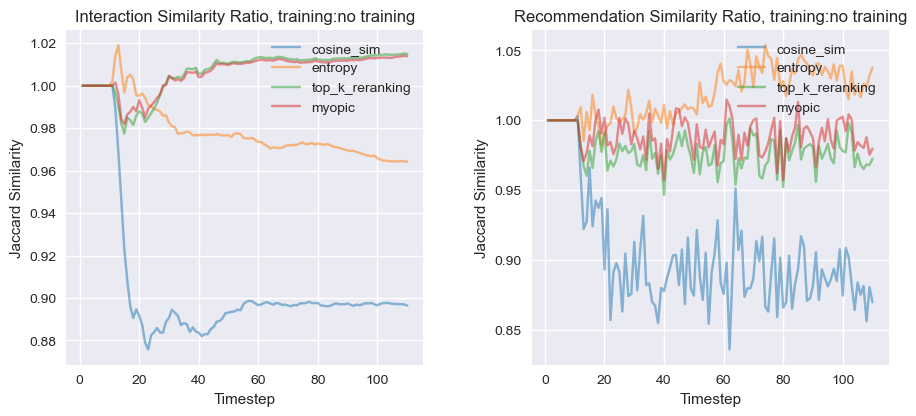

In [151]:
list = []

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=5.0)
colors = plt.get_cmap('tab10')

# plot rec_similarity with timesteps on x axis
# idxs = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1), (3,0), (3,1)]
idxs = [0,1]
legend_lines, legend_names = [], []

ts = dfs_homogen[0]['timesteps']

for i in range(4):
    
    print(paths[i])
    print(paths[i+4], "\n")
    ratio1 = (np.divide(dfs_homogen[i]['intra_cluster_interaction_similarity'], dfs_homogen[i]['inter_cluster_interaction_similarity']))
    ratio2 = (np.divide(dfs_homogen[i+4]['intra_cluster_interaction_similarity'], dfs_homogen[i+4]['inter_cluster_interaction_similarity']))
    ratio_ratios = np.divide(ratio1, ratio2)
    
    line, = ax[idxs[0]].plot(ts, ratio_ratios, label=paths[i][0], alpha=0.5, color=colors(i))
    
    ratio1 = (np.divide(dfs_homogen[i]['intra_cluster_rec_similarity'], dfs_homogen[i]['inter_cluster_rec_similarity']))
    ratio2 = (np.divide(dfs_homogen[i+4]['intra_cluster_rec_similarity'], dfs_homogen[i+4]['inter_cluster_rec_similarity']))
    ratio_ratios = np.divide(ratio1, ratio2)
    
    ax[idxs[1]].plot(ts, ratio_ratios, label=paths[i][0], alpha=0.5, color=colors(i))
    
    legend_lines.append(line)
    
for a in ax:
        a.set_xlabel('Timestep')

title_suffix = '(Training between timesteps)'

ax[idxs[0]].set_title(f"Interaction Similarity Ratio, training:no training")#\n{title_suffix}")
ax[idxs[0]].set_ylabel('Jaccard Similarity')

ax[idxs[1]].set_title(f"Recommendation Similarity Ratio, training:no training")#\n{title_suffix}")
ax[idxs[1]].set_ylabel('Jaccard Similarity')

for i in idxs:
    ax[i].legend(loc='upper right')

plt.savefig('figures/ratio_of_ratios_homogen_analysis.png')